In [438]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
import h5py # reccommended by the interpreter (weird) for loading older `.mat` files
import time

In [409]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the gop benchmark
# device = torch.device('cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# Importing the Dataset

In [410]:
class NYUDepthDataset (Dataset):
	def __init__(self, file_path, transform=None, target_transform=None):
		self.file_path = file_path
		self.data = h5py.File(file_path, 'r')
		self.transform = transform
		self.target_transform = target_transform

	def __len__(self):
		return len(self.data['images'])
	
	def __getitem__(self, idx):
		rgb_image = np.swapaxes(self.data['images'][idx], 0, 2)
		depth_image = np.swapaxes(self.data['depths'][idx], 0, 1)

		# print(rgb_image.shape)

		if self.transform:
			# print(torch.from_numpy(rgb_image).size())
			rgb_image = self.transform(rgb_image)
		if self.target_transform:
			depth_image = self.target_transform(depth_image)
			# depth_image -= depth_image.min()
			# depth_image /= depth_image.max()

		return rgb_image, depth_image

In [411]:
def show_grid(size, images, text=None):
	figure, axs = plt.subplots(nrows=size[0], ncols=size[1])
	figure.tight_layout()

	for i in range(len(axs)):
		for j in range(len(axs[i])):
			axs[i][j].imshow(images[i*len(axs[i]) + j])
			axs[i][j].set_xticks([])
			axs[i][j].set_yticks([])
			if text:
				axs[i][j].set_title(text[i*len(axs[i]) + j])


Image Data: 1449 images of size torch.Size([3, 480, 640])
tensor([[[2.7520, 2.7521, 2.7522,  ..., 2.2429, 2.2429, 2.2428],
         [2.7520, 2.7520, 2.7522,  ..., 2.2429, 2.2428, 2.2428],
         [2.7518, 2.7519, 2.7520,  ..., 2.2428, 2.2427, 2.2427],
         ...,
         [2.1981, 2.1980, 2.1979,  ..., 2.0813, 2.0811, 2.0809],
         [2.1980, 2.1979, 2.1978,  ..., 2.0816, 2.0813, 2.0812],
         [2.1979, 2.1979, 2.1977,  ..., 2.0818, 2.0815, 2.0813]]])


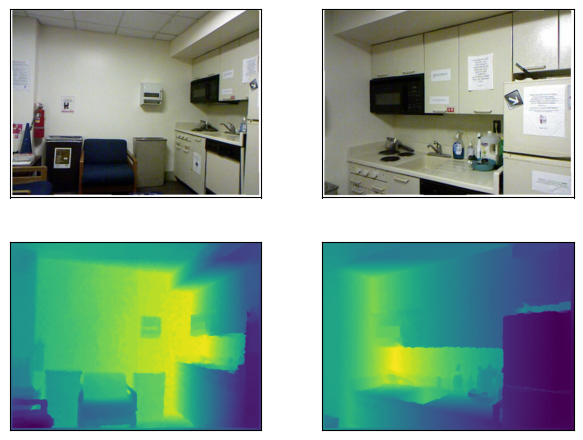

In [412]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=(0, 0, 0), std=(255, 255, 255))
])

depth_transform = transforms.Compose([
	transforms.ToTensor()
])

rng = torch.Generator().manual_seed(420)

NYU_data = NYUDepthDataset('data/NYU/nyu_depth_v2_labeled.mat', transform=transform, target_transform=depth_transform)
NYU_training, NYU_testing = random_split(NYU_data, (0.85, 0.15), generator=rng)

image_width, image_height = NYU_data[0][1].shape[1:]
num_shown = 2

def npImage(tensor):
	return np.swapaxes(np.swapaxes(tensor.detach().numpy(), 0, 2), 0, 1)

plot_images = [npImage(torch.mul(NYU_data[i][0], 255)) for i in range(num_shown)]
plot_images.extend([npImage(NYU_data[i][1]) for i in range(num_shown)])

print(f'Image Data: {len(NYU_data)} images of size {NYU_data[0][0].shape}')
print(NYU_data[0][1])
show_grid((2, num_shown), plot_images)

# Initialising the Model

In [413]:
class fDense (nn.Module):
	class compoundLayer (nn.Module):
		def __init__(self, inChannels, k):
			super().__init__()
			self.norm = nn.BatchNorm2d(inChannels)
			self.conv = nn.Conv2d(inChannels, k, 3, stride=1, padding=1, padding_mode='reflect', bias=True)
		
		def forward(self, x):
			intermediateOutput = F.relu(self.norm(x))
			x = torch.cat((x, self.conv(intermediateOutput)), dim=1)
			return x


	def __init__(self, inChannels, outChannels, l=4, k=32):
		super().__init__()
		modules = nn.ModuleList()
		for i in range(l):
			# the input channel count for layer i+1 is k_{i+1} = k_0 + ik
			modules.append(fDense.compoundLayer(inChannels + k*i, k))
		
		# 1x1 convolution to remap to correct channel number
		modules.append(nn.Conv2d(inChannels + k*l, outChannels, 1).to(device))

		self.layers = nn.Sequential(*modules)

	def forward(self, x):
		return self.layers(x)

In [414]:
class SE (nn.Module):
	def __init__(self, inChannels, outChannels, w, h):
		super().__init__()
		self.scalarUpsample = nn.Upsample((w, h))
		self.globalPool = nn.AvgPool2d((w, h))
		self.fc1 = nn.Linear(1, 1)
		self.fc2 = nn.Linear(1, 1)

		self.conv = nn.Conv2d(inChannels, outChannels, 1)

	def forward(self, x):
		scalars = self.globalPool(x)
		scalars = F.relu(self.fc1(scalars))
		scalars = F.sigmoid(self.fc2(scalars))
		scalars = self.scalarUpsample(scalars)
		x = self.conv(torch.mul(x, scalars))
		return x

In [415]:
class DisparityConvolution (nn.Module):
	def __init__(self, inChannels):
		super().__init__()
		self.conv = nn.Conv2d(inChannels, 1, 3, stride=1, padding=1, padding_mode='reflect', bias=True)
	
	def forward(self, x):
		# paper uses sigmoid, switching to relu for data
		# x = F.sigmoid(self.conv(x))
		x = F.relu(self.conv(x))
		return x

In [416]:
class FastMDE (nn.Module):
	inputSize = (0, 0)
	layers = []

	def __init__(self, w, h):
		super().__init__()
		self.inputSize = (w, h)

		self.pool = nn.MaxPool2d(2)
		self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
		self.upsampleToOrig = nn.Upsample(size=(w, h), mode='nearest')

		# several layers of increasing channels and decreasing resolutions
		
		self.feature1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)
		self.feature2 = nn.Sequential(nn.Conv2d(16, 24, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)
		self.feature3 = nn.Sequential(nn.Conv2d(24, 32, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)
		self.feature4 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)
		self.feature5 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1, padding_mode='reflect'), self.pool)

		self.ese4 = SE(192, 128, w//16, h//16)
		self.ese3 = SE(96, 64, w//8, h//8)
		self.ese2 = SE(56, 32, w//4, h//4)
		self.ese1 = SE(40, 24, w//2, h//2)

		self.fDense5 = nn.Sequential(fDense(128, 128), self.upsample)
		self.fDense4 = nn.Sequential(fDense(128, 128), self.upsample)
		self.fDense3 = nn.Sequential(fDense(64, 64), self.upsample)
		self.fDense2 = nn.Sequential(fDense(32, 32), self.upsample)
		self.fDense1 = nn.Sequential(fDense(72, 72), self.upsample)

		self.dse4 = nn.Sequential(nn.Conv2d(320, 320, 3, stride=1, padding=1, padding_mode='reflect'), SE(320, 128, w//16, h//16))
		self.dse3 = nn.Sequential(nn.Conv2d(224, 224, 3, stride=1, padding=1, padding_mode='reflect'), SE(224, 64, w//8, h//8))
		self.dse2 = nn.Sequential(nn.Conv2d(120, 120, 3, stride=1, padding=1, padding_mode='reflect'), SE(120, 32, w//4, h//4))
		self.dse1 = nn.Sequential(nn.Conv2d(72, 72, 3, stride=1, padding=1, padding_mode='reflect'), SE(72, 16, w, h))

		self.disparity1 = DisparityConvolution(16)
		self.disparity2 = DisparityConvolution(32)
		self.disparity3 = DisparityConvolution(64)
		self.disparity4 = DisparityConvolution(128)

		print(self)

	def forward(self, x):
		layer1 = self.feature1(x)
		layer2 = self.feature2(layer1)
		layer3 = self.feature3(layer2)
		layer4 = self.feature4(layer3)
		layer5 = self.feature5(layer4)

		layer6 = self.ese4(torch.cat((self.upsample(layer5), layer4), dim=1))
		layer7 = self.ese3(torch.cat((self.upsample(layer4), layer3), dim=1))
		layer8 = self.ese2(torch.cat((self.upsample(layer3), layer2), dim=1))
		layer9 = self.ese1(torch.cat((self.upsample(layer2), layer1), dim=1))

		layer10 = self.fDense5(layer5)
		layer11 = self.dse4(torch.cat((layer10, layer6, layer4), dim=1))
		layer12 = self.fDense4(layer11)
		layer13 = self.dse3(torch.cat((layer12, layer7, layer3), dim=1))
		layer14 = self.fDense3(layer13)
		layer15 = self.dse2(torch.cat((layer14, layer8, layer2), dim=1))
		layer16 = self.fDense2(layer15)
		layer17 = self.fDense1(torch.cat((layer16, layer9, layer1), dim=1))
		layer18 = self.dse1(layer17)

		outputScale1 = self.disparity1(layer18)
		outputScale2 = self.upsampleToOrig(self.disparity2(layer15))
		outputScale3 = self.upsampleToOrig(self.disparity3(layer13))
		outputScale4 = self.upsampleToOrig(self.disparity4(layer11))

		return torch.cat((outputScale1, outputScale2, outputScale3, outputScale4), dim=1)

In [417]:
model = FastMDE(image_width, image_height).to(device)

FastMDE(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
  (upsampleToOrig): Upsample(size=(480, 640), mode='nearest')
  (feature1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2

In [418]:
def getNumParams(model):
	pp=0
	for p in list(model.parameters()):
		nn=1
		for s in list(p.size()):
			nn = nn*s
		pp += nn
	return pp

print(getNumParams(model))

2618492


torch.Size([2, 4, 480, 640])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


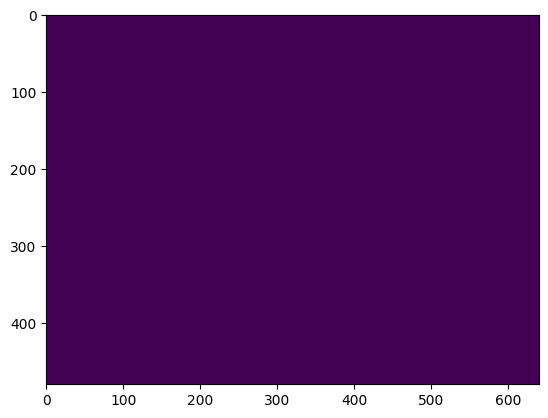

In [419]:
output = model.forward(default_collate([NYU_data[i][0].to(device) for i in range(2)]))
print(output.size())
plt.imshow(npImage(output[0,:1].cpu()))
print(output[0][0].cpu().detach().numpy())

In [420]:
# but for now
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

# add a loss fn that takes into account each scale of output, maybe? compares with pooled ground truth?

def multiScaleLoss(outputScales, expected):
	expectedStack = torch.cat((expected, expected, expected, expected), dim=1)
	return criterion(outputScales, expectedStack)

# and try Adam optimizer
# optimizer = SGD(model.parameters(), lr=0.00005, momentum=0.9)
optimizer = Adam(model.parameters(), lr=5e-5)

In [421]:
NYU_trainingDataLoader = DataLoader(NYU_training, batch_size=8, shuffle=True, num_workers=0)
NYU_testingDataLoader = DataLoader(NYU_testing, batch_size=8, shuffle=True, num_workers=0)

def train_one_epoch(model, epoch_index):
	running_loss = 0.

	for inputs, groundTruth in iter(NYU_trainingDataLoader):
		inputs = inputs.to(device)
		groundTruth = groundTruth.to(device)

		# Zero your gradients for every batch!
		optimizer.zero_grad()

		# Make predictions for this batch
		outputScales = model(inputs)
		
		# Compute the loss and its gradients
		loss = multiScaleLoss(outputScales, groundTruth)
		loss.backward()

		# Adjust learning weights
		optimizer.step()

		# Gather data and report
		running_loss += loss.item()

	return running_loss / len(NYU_trainingDataLoader)

In [422]:
load = True
if load: model.load_state_dict(torch.load('states/epoch_16.pt'))

In [423]:
EPOCHS = 20

losses, v_losses = [], []

for epoch in range(16, EPOCHS):
	print(f'-=-=-=-=- EPOCH {epoch + 1} -=-=-=-=-')
	print('training')
	# Make sure gradient tracking is on, and do a pass over the data
	model.train(True)
	avg_loss = train_one_epoch(model, epoch)
	losses.append(avg_loss)


	running_vloss = 0.0
	# Set the model to evaluation mode, disabling dropout and using population
	# statistics for batch normalization.
	model.eval()

	print('validating')
	# Disable gradient computation and reduce memory consumption.
	with torch.no_grad():
		for vinputs, vlabels in iter(NYU_testingDataLoader):
			vinputs = vinputs.to(device)
			vlabels = vlabels.to(device)

			voutputs = model(vinputs)
			vloss = multiScaleLoss(voutputs, vlabels)
			running_vloss += vloss

	avg_vloss = running_vloss / (i + 1)
	v_losses.append(avg_vloss)

	print(f'Training loss (MSE): {avg_loss}')
	print(f'Testing loss (MSE): {avg_vloss}')

	torch.save(model.state_dict(), f'states/epoch_{epoch + 1}.pt')

-=-=-=-=- EPOCH 17 -=-=-=-=-
training
validating
Training loss (MSE): 0.917885826973172
Testing loss (MSE): 24184.025390625
-=-=-=-=- EPOCH 18 -=-=-=-=-
training
validating
Training loss (MSE): 0.8867019883223942
Testing loss (MSE): 29.733301162719727
-=-=-=-=- EPOCH 19 -=-=-=-=-
training
validating
Training loss (MSE): 0.8314004261772354
Testing loss (MSE): 609.1596069335938
-=-=-=-=- EPOCH 20 -=-=-=-=-
training
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 233.76614379882812


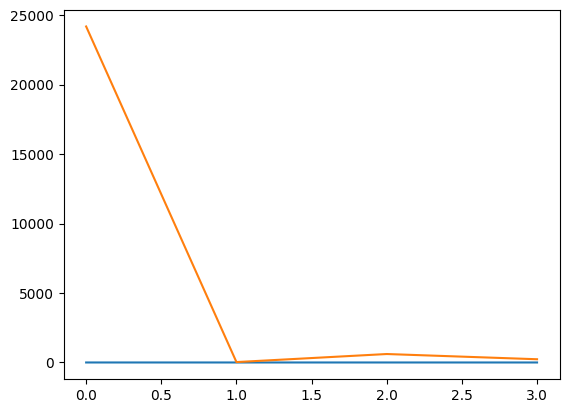

In [424]:
v_losses = [l.cpu() for l in v_losses]

currentTime = time.localtime()

with open(f'output/losses_{currentTime.tm_year}-{currentTime.tm_mon}-{currentTime.tm_mday}_[{currentTime.tm_hour}-{currentTime.tm_min}-{currentTime.tm_sec}].csv', 'w') as f:
	fileBody = 'loss,val loss\n'
	for i in range(len(losses)):
		fileBody += f'{losses[i]},{v_losses[i]}\n'
	f.write(fileBody)


plt.plot(range(len(losses)), losses)
plt.plot(range(len(v_losses)), v_losses)

[[[9.191099  9.190677  9.190652  ... 9.954083  9.954266  9.954278 ]
  [9.190999  9.190633  9.19146   ... 9.953967  9.954089  9.954122 ]
  [9.189994  9.189905  9.192838  ... 9.953081  9.953093  9.95304  ]
  ...
  [8.545416  8.546938  8.548975  ... 8.647572  8.649576  8.650087 ]
  [8.5469055 8.547279  8.546047  ... 8.647987  8.650161  8.650739 ]
  [8.547719  8.546942  8.545396  ... 8.648207  8.650228  8.650824 ]]]


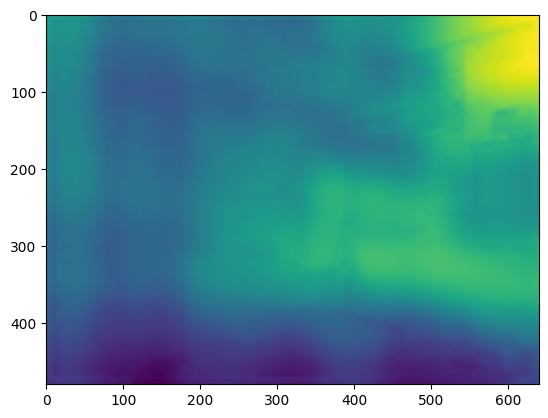

In [425]:
output = model.forward(default_collate([NYU_data[i+20][0].to(device) for i in range(2)]))

plt.imshow(npImage(output[0,:1].cpu()))
print(output[0,:1].cpu().detach().numpy())

Image Data: 1449 images of size torch.Size([3, 480, 640])


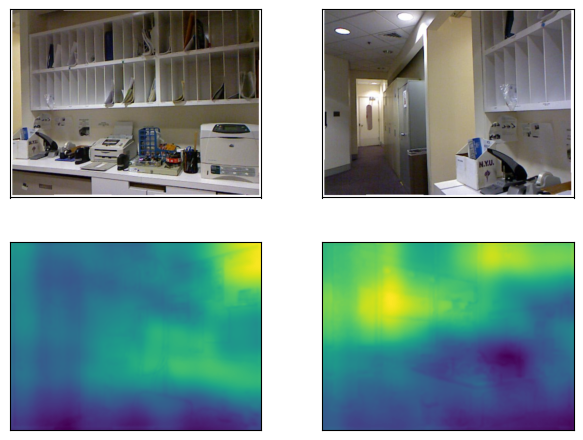

In [433]:
plot_images = [npImage(torch.mul(NYU_data[i+10][0], 255)) for i in range(num_shown)]
plot_images.extend([npImage(img[:1].cpu()) for img in output])

print(f'Image Data: {len(NYU_data)} images of size {NYU_data[0][0].shape}')

show_grid((2, num_shown), plot_images)

In [436]:
losses, v_losses = [], []

model.eval()

for epoch in range(EPOCHS):
	print(f'-=-=-=-=- EPOCH {epoch + 1} -=-=-=-=-')
	# print('training')
	# # Make sure gradient tracking is on, and do a pass over the data
	# model.train(True)
	# avg_loss = train_one_epoch(model, epoch)
	# losses.append(avg_loss)
	model.load_state_dict(torch.load(f'states/epoch_{epoch+1}.pt'))

	running_vloss = 0.0
	# Set the model to evaluation mode, disabling dropout and using population
	# statistics for batch normalization.

	print('validating')
	# Disable gradient computation and reduce memory consumption.
	with torch.no_grad():
		for vinputs, vlabels in iter(NYU_testingDataLoader):
			vinputs = vinputs.to(device)
			vlabels = vlabels.to(device)

			voutputs = model(vinputs)
			vloss = multiScaleLoss(voutputs, vlabels)
			running_vloss += vloss

	avg_vloss = running_vloss / (i + 1)
	v_losses.append(avg_vloss)

	print(f'Training loss (MSE): {avg_loss}')
	print(f'Testing loss (MSE): {avg_vloss}')

	torch.save(model.state_dict(), f'states/epoch_{epoch + 1}.pt')

-=-=-=-=- EPOCH 1 -=-=-=-=-
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 27679.69140625
-=-=-=-=- EPOCH 2 -=-=-=-=-
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 420.69610595703125
-=-=-=-=- EPOCH 3 -=-=-=-=-
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 68.55069732666016
-=-=-=-=- EPOCH 4 -=-=-=-=-
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 38.97685241699219
-=-=-=-=- EPOCH 5 -=-=-=-=-
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 433.8793029785156
-=-=-=-=- EPOCH 6 -=-=-=-=-
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 42.23793029785156
-=-=-=-=- EPOCH 7 -=-=-=-=-
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 20.429203033447266
-=-=-=-=- EPOCH 8 -=-=-=-=-
validating
Training loss (MSE): 0.8511190772443623
Testing loss (MSE): 42.37397766113281
-=-=-=-=- EPOCH 9 -=-=-=-=-
validating
Training loss (MSE): 0.851

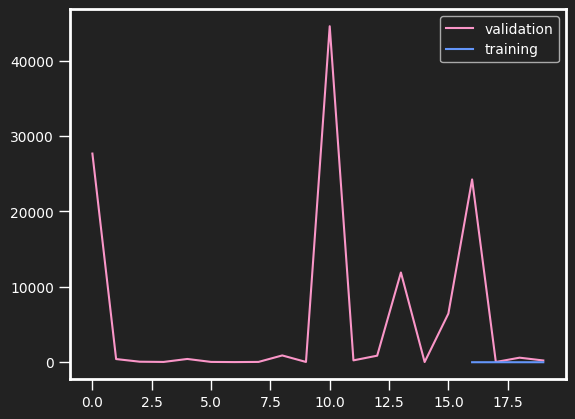

In [460]:
v_losses = [l.cpu() for l in v_losses]

currentTime = time.localtime()

with open(f'output/losses_{currentTime.tm_year}-{currentTime.tm_mon}-{currentTime.tm_mday}_[{currentTime.tm_hour}-{currentTime.tm_min}-{currentTime.tm_sec}].csv', 'w') as f:
	fileBody = 'loss,val loss\n'
	for i in range(len(losses)):
		fileBody += f'{losses[i]},{v_losses[i]}\n'
	f.write(fileBody)

mpl.rc('axes', facecolor='#222222', edgecolor='white', linewidth='2.0')
mpl.rc('figure', facecolor='#222222')
mpl.rc('xtick', color='white')
mpl.rc('xtick.major', width='1', size='8')
mpl.rc('ytick', color='white')
mpl.rc('ytick.major', width='1', size='8')
mpl.rc('text', color='white')

losses = [0.917885826973172, 0.8867019883223942, 0.8314004261772354, 0.8511190772443623]

v_loss_x = []
v_loss_y = []

for x, y in enumerate(v_losses):
	# if y < 1000:
	v_loss_x.append(x)
	v_loss_y.append(y)

plt.plot(v_loss_x, v_loss_y, label='validation', color='#fa96c8')
plt.plot(range(16, 20), losses, label='training', color='#6496fa')
plt.legend()

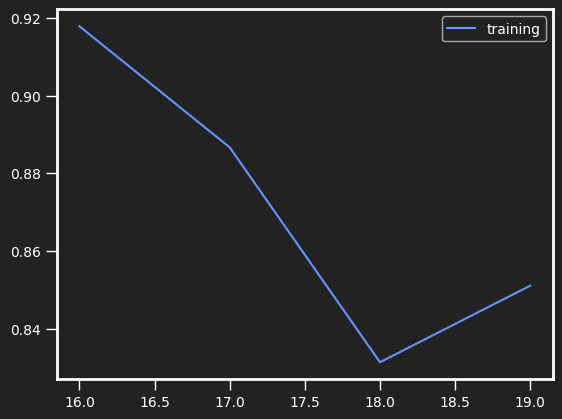

In [459]:
losses = [0.917885826973172, 0.8867019883223942, 0.8314004261772354, 0.8511190772443623]

plt.plot(range(16, 20), losses, label='training', color='#6496fa')
plt.legend()